# Test and log metrics for the dataset of the research project

This notebook uses the model class, loads the saved model and tokenizer and evaluates the chosen model on the "forschungsprojekt.xls" dataset. <br>

The script automatically logs the data in wandb as well as in the Excel file logged_model_metrics.xlsx which is also used for logging in my Model training code.

One section was used from Daniels Code this is marked in the code with a comment.

In [1]:
# Import packages
import os
import pandas as pd
import torch
from torch import nn
from transformers import BertModel, AutoTokenizer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    fbeta_score,
    matthews_corrcoef
)
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from google.colab import drive, runtime, userdata
import threading
import wandb
import datetime

In [2]:
# Configure Logging
logging.basicConfig(
    level=logging.INFO,  # Log INFO
    format="%(asctime)s - %(levelname)s - %(message)s",
    force=True
)

logger = logging.getLogger(__name__)

In [3]:
# Set Device to GPU / show GPU connection
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU Name: {torch.cuda.get_device_name(0)}")

2025-01-05 13:44:54,500 - INFO - Using device: cuda
2025-01-05 13:44:54,524 - INFO - GPU Name: NVIDIA A100-SXM4-40GB


### Bert + additional fully connected Layer

In [4]:
class BERT_WithExtraLayer(nn.Module):
    def __init__(self, bert_model_name, num_labels=2, hidden_dim=256, dropout_rate=0.1, class_weights=None):

        super(BERT_WithExtraLayer, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = self.bert.config.hidden_size

        # Additional fully connected layer
        self.extra_fc = nn.Linear(self.hidden_size, hidden_dim)
        self.relu = nn.ReLU()

        # Final classification layer
        self.classifier = nn.Linear(hidden_dim, num_labels)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask=None, labels=None):

        # Forward pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Shape: (batch_size, hidden_size)

        # Forward pass through extra layer
        x = self.extra_fc(pooled_output)
        x = self.relu(x)
        x = self.dropout(x)

        # Classification layer
        logits = self.classifier(x)  # Shape: (batch_size, num_labels)

        # Compute loss if labels are provided
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=class_weights) # for balancing the classes
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
            return loss, logits

        return logits


## Load data, model, tokenizer from google drive

In [5]:
# mount google drive for folder access
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
file_name = 'annotated_comments_gutefrage_final.csv'
dataset_path = os.path.join("/content/drive/MyDrive/model/data", file_name)

data = pd.read_csv(dataset_path, encoding='utf-8-sig', sep=';')
data['comment'] = data['comment'].astype(str)
data['annotation'] = data['annotation'].astype(int)
logger.info(f"Dataset loaded with shape: {data.shape}")


2025-01-05 13:45:13,064 - INFO - Dataset loaded with shape: (12929, 2)


In [7]:
model_name =  'model_extra_Layer_trial_33_2025-01-05_05-14.bin'

model_dir = '/content/drive/MyDrive/model/best_model_extra_Layer_2025-01-05_05-14'

model_path = os.path.join(model_dir, model_name)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Initialize model
model = BERT_WithExtraLayer(bert_model_name='deepset/gbert-base', num_labels=2)


# Load state dict
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

<ipython-input-7-dbf2a22e8e84>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


BERT_WithExtraLayer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Ensure the wandb connection closes and the session terminates

In [8]:
def safe_wandb_finish(timeout=45):
    """Safely terminates wandb.finish() with a timeout."""
    def finish_task():
        try:
            import wandb
            wandb.finish()
        except Exception as e:
            logger.error(f"Error in wandb.finish(): {e}")

    finish_thread = threading.Thread(target=finish_task)
    finish_thread.start()
    finish_thread.join(timeout=timeout)  # Wait for up to `timeout` seconds

    if finish_thread.is_alive():
        logger.warning("wandb.finish() timed out. Proceeding with runtime.unassign().")
    else:
        logger.info("wandb.finish() completed successfully.")

In [9]:

wandbkey = userdata.get('WandbKey')

wandb.login(key=wandbkey)

# Initialize the wandb runf
config = {
    "model_name": model_name,
    "dataset": file_name
}

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

run_name = f"{model_name}_{file_name}_{timestamp}"

wandb.init(project="German_Hate_Speech_Classification", name=run_name, id=run_name, config=config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxnienh (maxnienh-xx). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Process data and evaluate the metrics

The code logs the data to wandb as well as to the Excel file logged_model_metrics.xlsx which is also used for logging in my Model training code

2025-01-05 13:46:06,274 - INFO - ### Classification Metrics ###
2025-01-05 13:46:06,276 - INFO - Accuracy: 0.7738
2025-01-05 13:46:06,277 - INFO - Precision: 0.6438
2025-01-05 13:46:06,279 - INFO - Recall: 0.4320
2025-01-05 13:46:06,280 - INFO - F1 Score: 0.5170
2025-01-05 13:46:06,281 - INFO - F2 Score: 0.4624
2025-01-05 13:46:06,282 - INFO - Matthews Correlation Coefficient (MCC): 0.3895
2025-01-05 13:46:06,284 - INFO - S-Score: 0.5786
2025-01-05 13:46:06,289 - INFO - 
Confusion Matrix:
2025-01-05 13:46:06,289 - INFO - [[8440  866]
 [2058 1565]]


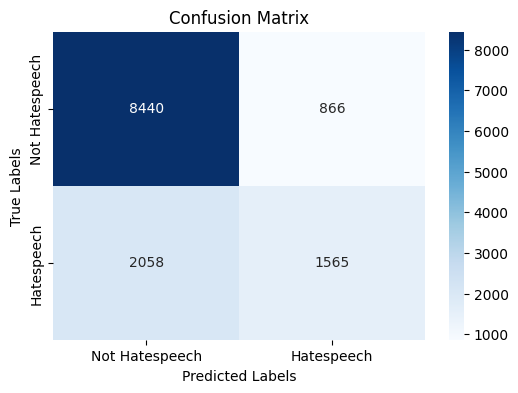

2025-01-05 13:46:07,514 - INFO - Metrics logged to Excel: /content/drive/MyDrive/model/logged_model_metrics.xlsx


test/S,▁
test/accuracy,▁
test/f1,▁
test/f2,▁
test/mcc,▁
test/precision,▁
test/recall,▁
test/S,0.57858
test/accuracy,0.77384
test/f1,0.51701
test/f2,0.46239


2025-01-05 13:46:09,151 - INFO - wandb.finish() completed successfully.
2025-01-05 13:46:09,153 - INFO - Process finished. Session will be terminated...


In [ ]:
def classify_text_batch(text_list, model, tokenizer, batch_size=32):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []

    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i : i + batch_size]
        inputs = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items() if k != "token_type_ids"}

        with torch.no_grad():
            logits = model(**inputs)
            probabilities = torch.softmax(logits, dim=1)
            batch_predictions = torch.argmax(probabilities, dim=1).tolist()

        predictions.extend(batch_predictions)

    return predictions


data['predicted_label'] = classify_text_batch(data['comment'].tolist(), model, tokenizer)


true_labels = data['annotation']
predicted_labels = data['predicted_label']
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
f2 = fbeta_score(true_labels, predicted_labels, beta=2, average='binary')
mcc = matthews_corrcoef(true_labels, predicted_labels)
mcc_normalized = (mcc + 1) / 2
S = (f2 + mcc_normalized) / 2

# Log metrics
logger.info("### Classification Metrics ###")
logger.info(f"Accuracy: {accuracy:.4f}")
logger.info(f"Precision: {precision:.4f}")
logger.info(f"Recall: {recall:.4f}")
logger.info(f"F1 Score: {f1:.4f}")
logger.info(f"F2 Score: {f2:.4f}")
logger.info(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
logger.info(f"S-Score: {S:.4f}")

# Log metrics to WandB
wandb.log({
    "test/accuracy": accuracy,
    "test/precision": precision,
    "test/recall": recall,
    "test/f1": f1,
    "test/f2": f2,
    "test/mcc": mcc,
    "test/S": S
})

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
logger.info("\nConfusion Matrix:")
logger.info(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hatespeech", "Hatespeech"], yticklabels=["Not Hatespeech", "Hatespeech"])
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")
plt.show()

# Save confusion matrix as artifact
#wandb.log({f"Confusion Matrix {model_name} / {file_name}": wandb.Image(plt)})

# Save metrics to Excel
excel_file_path = '/content/drive/MyDrive/model/logged_model_metrics.xlsx'
new_results = pd.DataFrame([{
    "Trial_Name": model_name,
    "Dataset": file_name,
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1,
    "test_f2": f2,
    "test_mcc": mcc,
    "test_S": S
}])

if os.path.exists(excel_file_path):
    existing_df = pd.read_excel(excel_file_path)
    updated_df = pd.concat([existing_df, new_results], ignore_index=True)
else:
    updated_df = new_results

updated_df.to_excel(excel_file_path, index=False)
logger.info(f"Metrics logged to Excel: {excel_file_path}")


# wandb.finish()
safe_wandb_finish(timeout=45)

logger.info("Process finished. Session will be terminated...")

# terminate session
runtime.unassign()